# 1. Using deterministic representations to predicting polymer properties with neural networks

In this workbook, we use RDKit to calculate a deterministic set of representations which can describe polymer structures. These are then passed to a simple neural network structure for predicting polymer properties.

You will:
   
*   Explore how RDKit can be used to calculate molecular properties from SMILES strings
*   Create representations of polymers using Morgan fingerprints
*   Train a simple neural network which uses these representations to predict properties.

In this example, we specifically look at predicting the "electron affinity" of polymers for photocatalytic water splitting. This value ("EA") is extremely important because it is approximately equal to the energy of photo-generated electrons participating in the water splitting reaction. The value of EA defines a necessary (but not sufficient) condition on a polymer's reaction efficiency.

Resources:
>RDKit:   
>https://rdkit.org/docs/index.html

>Data from:  
>https://pubs.acs.org/doi/full/10.1021/jacs.9b03591


##0. Install packages

In [ ]:
# RDKit (~30 sec)
!pip install rdkit -qq
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, DataStructs, rdFingerprintGenerator
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import IPythonConsole

# ML
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, PredefinedSplit

# Misc
import pandas as pd
import numpy as np
from natsort import natsorted

import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image

from tqdm import tqdm
import copy
import io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.6/36.6 MB 45.0 MB/s eta 0:00:00


##1. Import and explore data

> poly_ID = MonomerA_MonomerB  
> poly_SMI = polymer representation (A.B) in SMILES format.  
> EA = electron affinity ~ energy of electrons participating in the reaction. This is the target we wish to predict.    
> IP = ionisation potential = how much energy is required to fully eject an electron from the polymer. We won't use this today.

In [ ]:
# Get the polymer SMILES from GitHub.
csv_url = "https://raw.githubusercontent.com/S-AJ-H/AIMS26/25478252292fe3bde0e4fb06977ea21c7e05545a/dataset.csv"
df_data = pd.read_csv(csv_url)
display(df_data)

,poly_ID,poly_SMI,EA,IP
0,0_0,Fc1ccc(F)cc1.Oc1cc(O)cc(O)c1,-3.406210,1.808017
1,0_1,Fc1ccc(F)cc1.N#Cc1ccc(F)cc1,-2.472685,2.635116
2,0_2,Fc1ccc(F)cc1.Cc1cc(N)ccc1Cl,-3.459588,1.454940
3,0_3,Fc1ccc(F)cc1.O=C(Cl)COc1ccccc1,-2.842112,2.066126
4,0_4,Fc1ccc(F)cc1.COC(=O)c1cccc(N)n1,-2.724312,1.757542
...,...,...,...,...
6133,8_677,O=S1(=O)c2ccccc2-c2ccccc21.O=[N+]([O-])c1ccc(F...,-1.704934,2.202737
6134,8_678,O=S1(=O)c2ccccc2-c2ccccc21.O=C(O)c1cccs1,-2.010124,1.951355
6135,8_679,O=S1(=O)c2ccccc2-c2ccccc21.O=[N+]([O-])c1ccccn1,-1.718059,2.356684
6136,8_680,O=S1(=O)c2ccccc2-c2ccccc21.CC(Oc1ccccc1)C(=O)NN,-2.740288,1.583449


### 1.1 Chemistry with RDKit

> We construct 'molecule' objects from the SMILES using RDKit. RDKit uses a collection of rules to calculate a complete set of molecule-defining chemical information from the SMILES. These graph-based molecule objects encode the atomic structure, bonds, spatial arrangement etc of a molecule - we can then do digital chemistry with these!

> We can represent each polymer *[-A-B-]n* in a single RDKit 'molecule' object as a pair of monomers *A.B* :

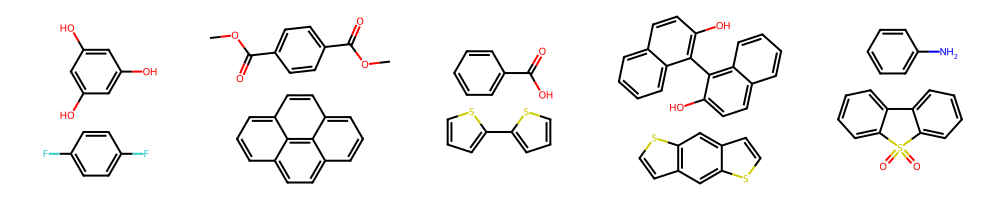

In [ ]:
# Convert the SMILES to mol objects using MolFromSmiles on each element in the Series:
df_chem = df_data.copy()
random_mols_index = [0,1000,2000,5000, 6137]                                                  # look at some random polymers
df_chem['poly_MOL'] = df_chem['poly_SMI'].iloc[random_mols_index].apply(Chem.MolFromSmiles)   # Chem.MolFromSmiles converts the SMILES into molecules

# Draw the pairs:
img = Draw.MolsToGridImage(list(df_chem.poly_MOL.iloc[random_mols_index]), molsPerRow=5)
display(img)

> As an example, lets calculate the partial charges for the last pair of monomers. The resulting graph shows where electrons are localised in the molecules (blue = higher electron density, red = electron deficient).

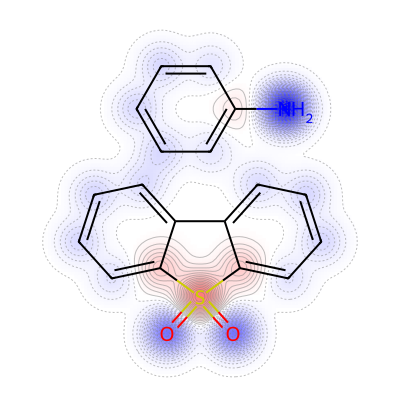

In [ ]:
# calculate partial charges
mol = df_chem.poly_MOL.iloc[6137]                                               # molecule representing the final pair of monomers (as example)
Chem.AllChem.ComputeGasteigerCharges(mol)                                       # calculate the partial charges
charges = [x.GetDoubleProp('_GasteigerCharge') for x in mol.GetAtoms()]         # store the partial charges, with same indexing as atoms

# plotting function
def show_image(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    display(img)

colours = [(0.0, 0.0, 1.0, 1.0), (1.0, 1.0, 1.0, 1.0), (1.0, 0.0, 0.0, 1.0)]    # define colour range (min = blue, med = white, max = red)
d = Draw.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol=mol,weights=charges,draw2d=d, colorMap=colours, contourLines=50)
d.FinishDrawing()
show_image(d.GetDrawingText())

> 1.1 Question: Look at the partial charge graph. Can you see the downside to representing a polymer as a pair of monomers? Hint: construct a partial charge graph for this SMILES: "Nc1cc(-c2ccc3c(c2)S(=O)(=O)c2ccccc2-3)ccc1"

In [ ]:
# Use this box to help answer Question 1.1

# calculate partial charges
mol = df_chem.poly_MOL.iloc[6137]
Chem.AllChem.ComputeGasteigerCharges(mol)
charges = [atom.GetDoubleProp('_GasteigerCharge') for atom in mol.GetAtoms()]
print(f"Partial charges: {charges}")

# draw
mol

##2. Generate a fixed representation for each material

> To predict the property "EA" of our polymers, we need to generate a representation of each polymer which can be passed to a feed forward neural network. This representation is made up of "fingerprints".

### 2.1 Understanding Morgan fingerprints

> There are a number of well-established, deterministic ways of making fingerprints. In this example, we use the popular "count Morgan fingerprints", which calculate a set of molecule-defining chemical fragments.
Count Morgan fingerprints are generated by iteratively encoding each atom’s local neighborhood up to a chosen radius into IDs. These are counted to record how many times each unique substructure occurs in the molecule. These identifiers are then hashed into positions of a fixed-length vector, with counts accumulated per index.

* The molecule fragment is drawn with the atoms in the same positions as in the original molecule.
* The original atom is highlighted in blue.
* Aromatic atoms are highlighted in yellow.
* Atoms/bonds that are drawn in light gray indicate parts of the structure which influence the atoms’ properties but are not directly part of the fingerprint (e.g. they might define whether an atom in in a ring or not).

Fingerprint Bit IDs: [64, 108, 147, 175, 207, 310, 352, 356, 389, 404, 433, 469, 496, 650, 697, 726, 780, 783, 849, 888, 924, 984]

Number of fingerprints: 22



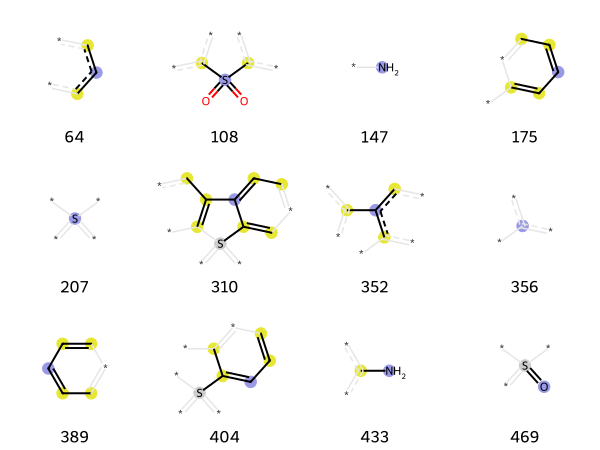

In [ ]:
mol = df_chem.poly_MOL.iloc[6137]

# Define Morgan fingerprints
mfp = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)          # radius = "look two atoms away from each atom". fpSize = length of feature vector
ao = rdFingerprintGenerator.AdditionalOutput()                                  # extract metadata for plotting
ao.AllocateBitInfoMap()

# Make fingerprints
fp = mfp.GetFingerprint(mol,additionalOutput=ao)
print(f"Fingerprint Bit IDs: {list(fp.GetOnBits())}\n")

# Draw last 12
tpls = [(mol,x,ao.GetBitInfoMap()) for x in fp.GetOnBits()]
print(f"Number of fingerprints: {len(fp.GetOnBits())}\n")
Draw.DrawMorganBits(tpls[:12],molsPerRow=4,legends=[str(x) for x in fp.GetOnBits()][:12])


### 2.2 Generating fingerprints for ML

In [ ]:
# define a function which calculates Morgan Fingerprints:
def generate_fingerprints(smiles, radius, nBits):

  # define fingerprints:
  mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=nBits)
  # Generate:
  mols = [Chem.MolFromSmiles(smi) for smi in smiles]                    # convert the smiles in the df into a list of molecular graphs "mols"
  individual_cfps = [mfpgen.GetCountFingerprint(mol) for mol in mols]   # Generate count Morgan fps
  #individual_cfps = [mfpgen.GetFingerprint(mol) for mol in mols]       # binary Morgan fps

  # "individual_cfps" are RDKit SparseIntVect objects which only store non-zero values.
  # To convert to NumPy arrays, we need to iterate over all molecules and add in the zeros:
  cfp_arrays = []
  for fp in individual_cfps:                                            # for each individual set of fingerprints (i.e. for each mol)
    array = np.zeros((nBits), dtype=int)                                # create an array of zeros of appropriate size
    DataStructs.ConvertToNumpyArray(fp, array)                          # RDKit function which copies the fingerprint into the array.
    cfp_arrays.append(array)                                            # store the fingerprints array in a list
  cfp = np.array(cfp_arrays)                                            # Convert the list of arrays to a single 2D NumPy array
  return cfp

In [ ]:
# define key parameters
nBits=1024                            # default 1024 - total length of feature vector
radius = 2                            # default 2 - how many adjacent atoms to consider, for each atom
smiles = df_data.loc[:, 'poly_SMI']   # from our imported data

# generate fingerprints
fingerprints = generate_fingerprints(smiles, radius, nBits)  # call our function from above, return an array

# Create a DataFrame combining our original data with newly generated fingerprints
fingerprint_df = pd.DataFrame(fingerprints, columns=[f'bit-{x}' for x in range(nBits)])
df = pd.concat([df_data, fingerprint_df], axis=1)
display(df.head())
# now we have the targets and the representations


SyntaxError: invalid syntax (ipython-input-2518286643.py, line 7)

  2. Questions:
  >Try switching between the count and binary Morgan fingerprint generators using 16 and 1024 nBits.    
  >Look up the difference between count and binary Morgan fingerprints. Why might you use one over the other?  
  > Why are 16 bits not enough to describe our polymers?

##3. Machine learning

> Now that we have representations that are ML-friendly, we can input them into a feedforward neural network and train the model to predict continuous target values.

###### 3.1 Define network architecture and parameters


In [ ]:
#Define the model architecture with two hidden layers:
num_epochs = 30
hidden_dim = 32
hidden_dim_2 = 32
dropout = 0.0
lr=1e-4
batch_size = 64
criterion = nn.MSELoss()
patience = 3                                                #for early stopping
scaler = StandardScaler()                                   #rescale to zero mean and unit variance

class SimpleNN(nn.Module):                                  #inherit from PyTorch Module class
    def __init__(self, input_dim=nBits, hidden_dim=hidden_dim, dropout=dropout):
        super(SimpleNN, self).__init__()                    #super calls nn.Module __init__ method, as there's lots in it
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, 1)
        )
    def forward(self, x):                                   #required as part of nn.Module, called automatically when running SimpleNN(x)
        return self.net(x)


##### 3.2 Extract and split features and targets

> Note: The training structure has designed to be easily adapted for K-fold cross-validation. In this workshop, we will train on the entire dataset, so any references to folds can be ignored.

In [ ]:
# Extract features (fingerprints) and targets (EA)
X = df.iloc[:, 4:].values                             # numpy array comprising all fingerprint columns [shape (6138,1024)]
y = df['EA'].values.reshape(-1, 1)                                   # numpy array comrpising the EA values [length (6138)]

#set up data splitting. Code is written for easy modification for cross-validation, but we ignore it here
fold = 1
n_splits = 1                                                                                                 # set only 1 fold
train_idx, valid_idx = train_test_split(range(len(smiles)), test_size=0.1, random_state=31, shuffle=True)   # get indices


##### 3.3 Define dataloader

In [ ]:
def dataloader(X, y, train_index, valid_index, batch_size, fold_scaler):
  # pull out the appropriate test and validation splits using the indexes
  X_train, X_valid = X[train_index], X[valid_index]
  y_train, y_valid = y[train_index], y[valid_index]

  y_train_scaled = fold_scaler.fit_transform(y_train)
  y_valid_scaled = fold_scaler.transform(y_valid)

  # Convert to PyTorch tensors with float32 dtype
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
  X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
  y_valid_tensor = torch.tensor(y_valid_scaled, dtype=torch.float32)

  # Create datasets and dataloaders
  train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
  valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, valid_loader

###### 3.4 Train and validate model

In [ ]:
# define our training loop:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(X), y)                                     #average loss per sample in batch
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)                             #batch loss = average loss in batch * batch size. Add batch loss to train_loss
    return total_loss / len(loader.dataset)                               #after for loop, train_loss is the total loss over entire dataset. Calc average per sample by dividing by num_train

# define our evaluation loop:
def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            total_loss += loss.item() * X.size(0)
    return total_loss / len(loader.dataset)


In [ ]:
#for storing all predictions and targets, for all folds
results = []
# for per-fold analysis
fold_r2_scores = []
fold_mae_scores = []
train_losses_dict = {}
valid_losses_dict = {}

#Per fold
for fold, (train_idx, valid_idx) in enumerate([(train_idx, valid_idx)], 1):
    # define (and reset) the model:
    train_losses, valid_losses = [], []
    fold_scaler = StandardScaler()
    train_loader, valid_loader = dataloader(X, y, train_idx, valid_idx, batch_size, fold_scaler)

    model = SimpleNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)                           # reduce the learning rate over time

    best_valid_loss = float('inf')                                                                      # for early stopping
    epochs_without_improvement = 0

    #train and evaluate:
    pbar = tqdm(range(num_epochs), desc=f"Fold {fold}")                                                 # make a tqdm object so we have a progress bar
    for epoch in pbar:
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)                   # call the training loop
        valid_loss = eval_epoch(model, valid_loader, criterion, device)                   # call the eval loop
        train_losses.append(train_loss)                                                                 # collect the per-fold, per-epoch losses for plotting
        valid_losses.append(valid_loss)

        #Early stopping:
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            epochs_without_improvement = 0
            best_model_state = model.state_dict()                                                        # save best weights
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered!")
                model.load_state_dict(best_model_state)                                                  # restore best weights if early stopping
                break

        #change learning rate and update progress bar
        pbar.set_postfix({"Train": f"{train_loss:.3f}", "Valid": f"{valid_loss:.3f}", "Best": f"{best_valid_loss:.3f}"})
        scheduler.step()

    model.load_state_dict(best_model_state)                                                              # restore best weights if no early stopping
    train_losses_dict[fold] = train_losses                                                               # store the per-fold, per-epoch losses with the key = fold number
    valid_losses_dict[fold] = valid_losses

    #Evaluate predictions and metrics per fold:
    preds, targets = [], []
    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            preds.append(outputs.cpu())                                                                   # cpu as upcoming NumPy and scikit-learn don't work with GPU tensors
            targets.append(batch_y.cpu())

    #Put fold results in a temporary dataframe (gets overwritten)
    fold_preds   = torch.cat(preds).numpy()                                                               # Concatenate all batch tensors into one NumPy array (NumPy as sklearn does not accept tensors)
    fold_targets = torch.cat(targets).numpy()
    fold_preds_unscaled = fold_scaler.inverse_transform(fold_preds.reshape(-1, 1))                        # Apply inverse scaling. reshape as sklearn wants 2D arrays.
    fold_targets_unscaled = fold_scaler.inverse_transform(fold_targets.reshape(-1, 1))

    df_fold = pd.DataFrame({
      "original_index": valid_idx,                                                                        # keep original indices, as we shuffled during the KFold but want to match to original smiles list
      "preds": fold_preds_unscaled.flatten(),                                                             # (flatten to 1D array)
      "targets": fold_targets_unscaled.flatten(),
      "fold": fold
    })
    results.append(df_fold)                                                                               #Save predictions and targets alongside fold number across all folds for later plotting

    #Compute metrics per fold
    r2 = r2_score(df_fold["targets"], df_fold["preds"])
    mae = mean_absolute_error(df_fold["targets"], df_fold["preds"])
    fold_r2_scores.append(r2)                                                                             # collect the per-fold r2 into a single list
    fold_mae_scores.append(mae)
    print(f"R²={r2:.3f}, MAE={mae:.3f}\n")

#After all folds:
#=================
# save all predictions in a dataframe
df_results = pd.concat(results, ignore_index=True)
df_all = df_data.merge(df_results, left_index=True, right_on="original_index")

# Aggregate across folds
mean_r2 = np.mean(fold_r2_scores)
mean_mae = np.mean(fold_mae_scores)
std_r2 = np.std(fold_r2_scores)
std_mae = np.std(fold_mae_scores)
print("\nFull results:")
print(f"Mean R²: {mean_r2:.3f} ± {std_r2:.3f}")
print(f"Mean MAE: {mean_mae:.3f} ± {std_mae:.3f}")

##### 3.5 Plot Results

In [ ]:
display(df_all)

In [ ]:
# Create subplots
n_plots = n_splits + 2  # train/val plots + scatter + bar
fig, axes = plt.subplots(3, 4, figsize=(15, 8))
axes = axes.flatten()

# Training vs Validation Loss per fold
for fold in range(1, n_splits+1):
    ax = axes[fold-1]
    ax.plot(train_losses_dict[fold], label=f"Train Fold {fold}", alpha=0.7)
    ax.plot(valid_losses_dict[fold], label=f"Valid Fold {fold}", alpha=0.7)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE Loss")
    ax.set_title(f"Fold {fold} Losses")
    ax.set_yscale("log")
    ax.legend()

# Scatter plot: True vs Predicted
ax2 = axes[n_splits]
for fold in range(1, n_splits+1):
    fold_data = df_all[df_all["fold"] == fold]
    ax2.scatter(
        fold_data["targets"],
        fold_data["preds"],
        alpha=0.8,
        s=5,
        label=f"Fold {fold}"
    )

ax2.set_xlabel("True EA")
ax2.set_ylabel("Predicted EA")
ax2.set_title("True vs Predicted EA")
lims = [
    min(df_all["targets"].min(), df_all["preds"].min()),
    max(df_all["targets"].max(), df_all["preds"].max())
]
ax2.plot(lims, lims, "r--")  # y=x reference
ax2.text(0.05, 0.95, f"R²: {mean_r2:.3f} ± {std_r2:.3f}",
         transform=ax2.transAxes, fontsize=10, verticalalignment='top')
ax2.text(0.05, 0.85, f"MAE: {mean_mae:.2f} ± {std_mae:.2f}",
         transform=ax2.transAxes, fontsize=10, verticalalignment='top')
ax2.legend(title="Folds", markerscale=2, loc="center left", bbox_to_anchor=(1.05, 0.5))

# Bar chart: MAE per fold
ax3 = axes[n_splits+1]
cmap = plt.cm.get_cmap("tab10")
colors = [cmap(fold-1) for fold in range(1, n_splits+1)]
ax3.bar(range(1, n_splits+1), fold_mae_scores, color=colors, edgecolor="black")
ax3.set_xlabel("Fold")
ax3.set_ylabel("MAE")
ax3.set_title("MAE per Fold")
ax3.set_xticks(range(1, n_splits+1))

# Delete any unused subplots
for i in range(n_splits+2, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()
